In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [28]:
df = pd.read_csv('airline_passenger_satisfaction.csv')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [30]:
df.drop("ID", axis=1, inplace=True)
df.dropna(axis=0, how='any', subset=None, inplace=True)
df['Satisfaction'] = df['Satisfaction'].map({'Neutral or Dissatisfied': 0, 'Satisfied': 1})

In [31]:
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop("Satisfaction", axis=1).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

X = df.drop('Satisfaction', axis=1)
y = df['Satisfaction']


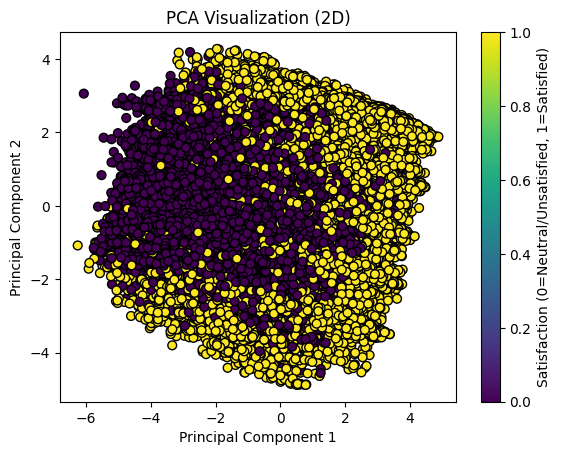

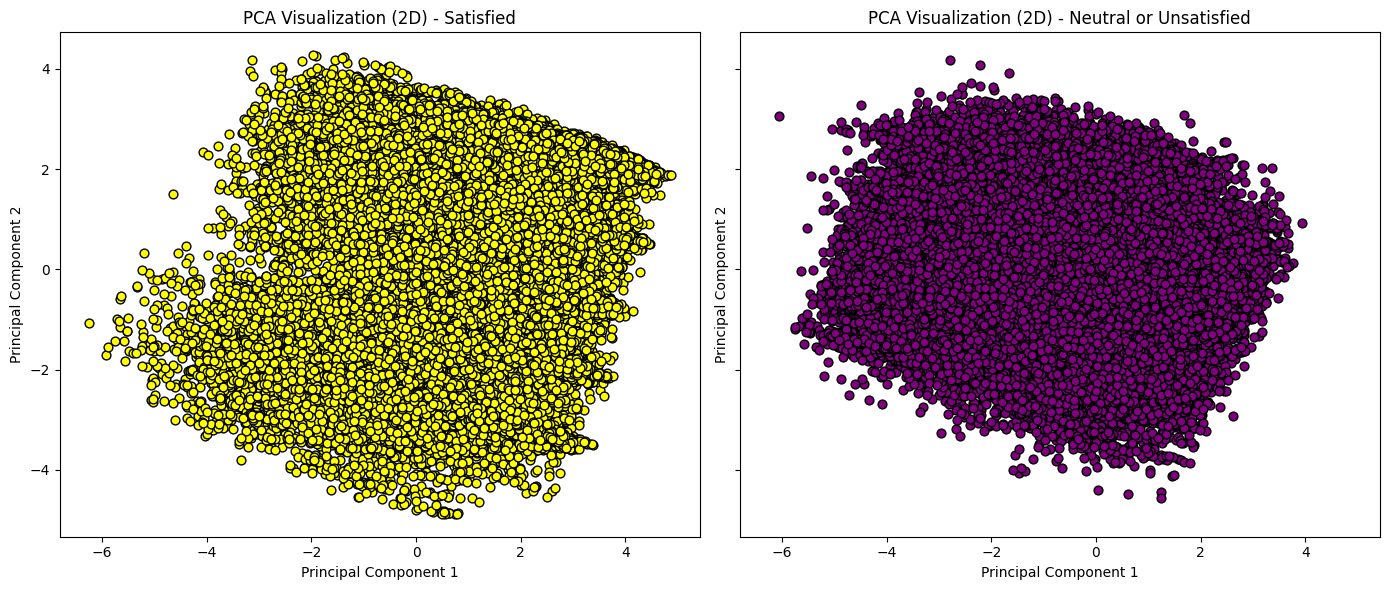

In [32]:

X_processed = preprocessor.fit_transform(X)
#X_processed = preprocessor.fit_transform(df)

pca = PCA(n_components=2)  # Retain 2 components for visualization
X_pca = pca.fit_transform(X_processed)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,
            cmap='viridis', edgecolor='k', s=40)
plt.title("PCA Visualization (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
plt.show()

X_pca_sat = X_pca[df['Satisfaction'] == 1]
X_pca_unsat = X_pca[df['Satisfaction'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)


axes[0].scatter(X_pca_sat[:, 0], X_pca_sat[:, 1], c = "yellow",
             edgecolor='k', s=40)
axes[0].set_title("PCA Visualization (2D) - Satisfied")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
#axes[0].colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
#plt.show()

axes[1].scatter(X_pca_unsat[:, 0], X_pca_unsat[:, 1], c = 'purple',
            edgecolor='k', s=40)
axes[1].set_title("PCA Visualization (2D) - Neutral or Unsatisfied")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

In [8]:
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=1000, n_iter=1000, n_jobs=-1)

sample_df, _ = train_test_split(df, stratify=df["Satisfaction"], test_size=0.9, random_state=42)

sample_X = sample_df.drop("Satisfaction", axis=1)

sample_X_processed = preprocessor.transform(sample_X)

# Fit and transform the data
X_tsne = tsne.fit_transform(sample_X_processed)



c:\Users\Athos\anaconda3\envs\TAAC_part2\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 

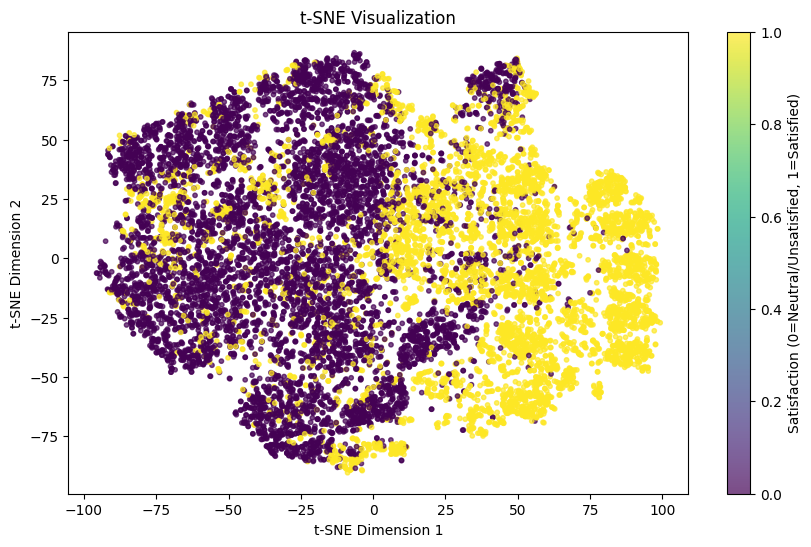

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_df['Satisfaction'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

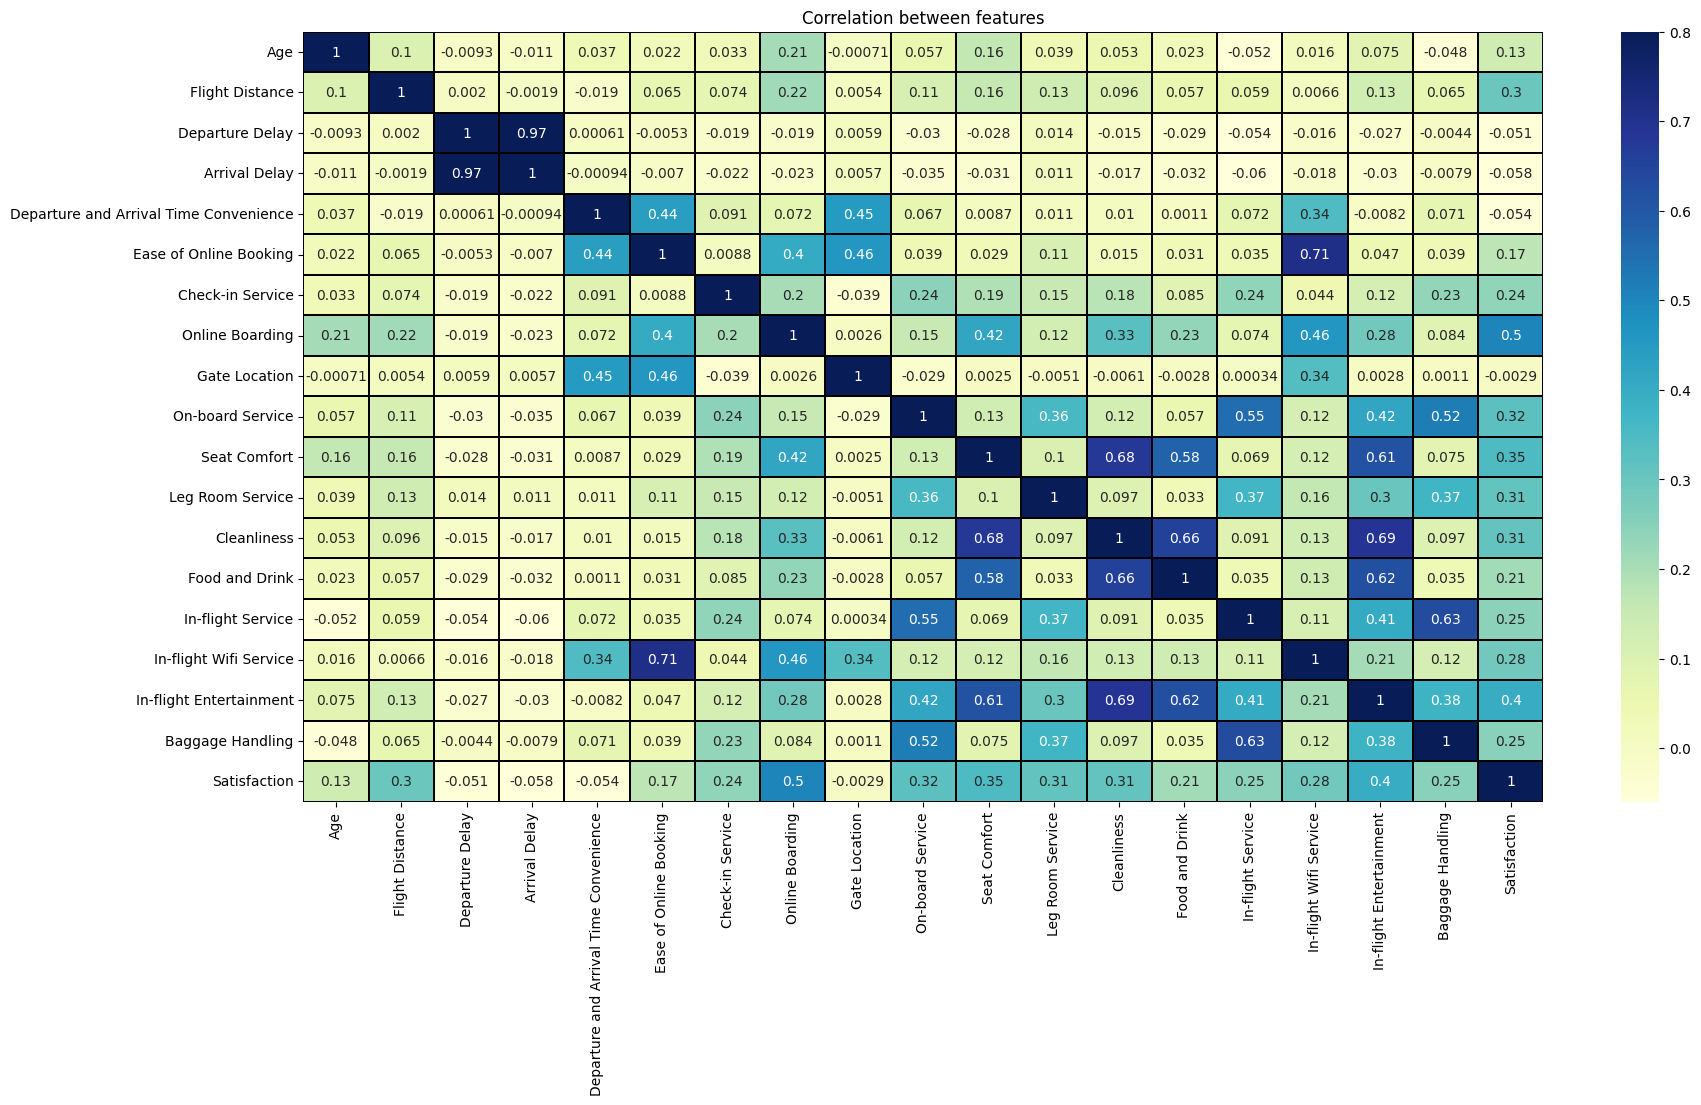

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(),  vmax=0.8, linewidth=0.01, annot = True, cmap='YlGnBu', linecolor ='black')
plt.title('Correlation between features')
plt.show()

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling
59647,Male,38,Returning,Business,Business,564,0,0.0,2,2,...,2,1,4,1,4,5,1,1,1,1
120798,Male,37,Returning,Business,Business,2060,0,0.0,5,5,...,5,5,4,5,3,2,5,5,5,5
80978,Female,30,Returning,Business,Business,2882,0,0.0,4,4,...,4,4,4,3,4,4,5,4,4,5
48070,Male,59,Returning,Business,Business,236,27,32.0,3,3,...,3,2,2,2,4,1,2,2,2,2
53503,Female,17,Returning,Personal,Economy,2419,0,3.0,2,5,...,3,5,1,3,1,5,3,5,4,4


Accuracy: 0.7790176847633021
Confusion Matrix:
[[12000  2685]
 [ 3038  8175]]


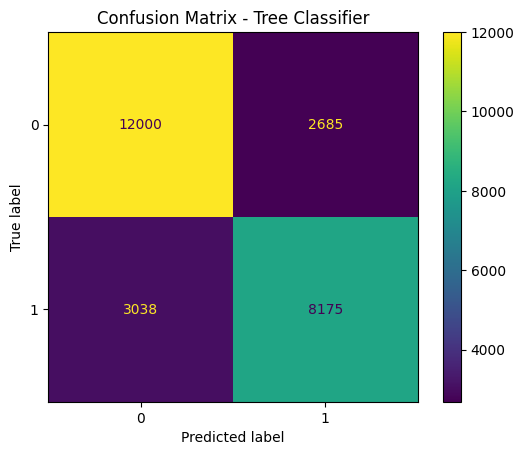

In [ ]:
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

# Step 4: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_clf =DecisionTreeClassifier(random_state=42, max_depth=3)

# Step 5: Create a pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('classifier', tree_clf)
])

# Step 6: Train the classifier
model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix - Tree Classifier')
plt.show()

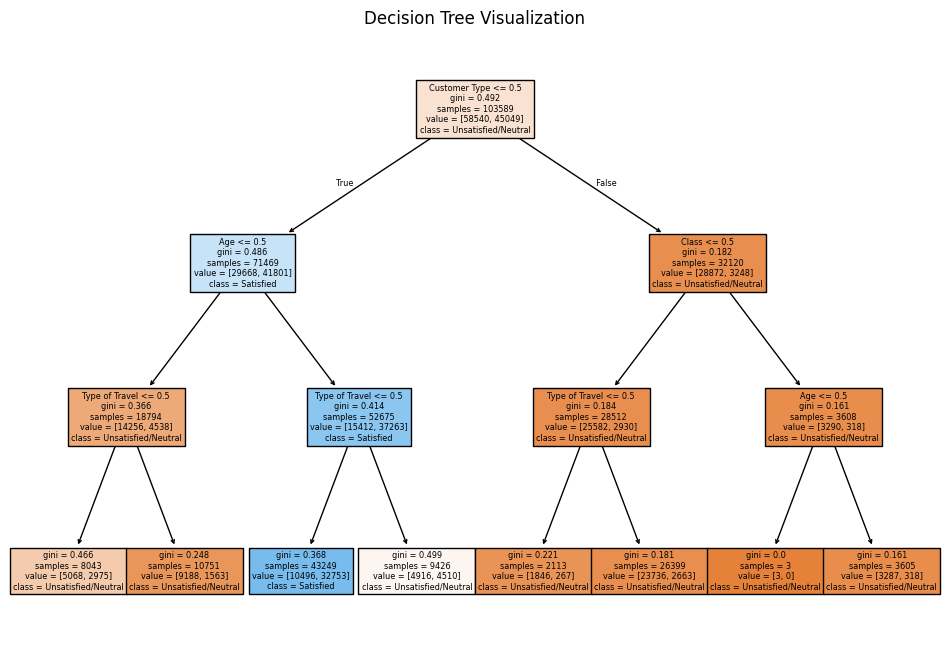

In [25]:
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=df.columns, class_names=['Unsatisfied/Neutral', 'Satisfied'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()